In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# # Set random seed for reproducibility
# manualSeed = 999
# #manualSeed = random.randint(1, 10000) # use if you want new results
# print("Random Seed: ", manualSeed)
# random.seed(manualSeed)
# torch.manual_seed(manualSeed)

In [2]:
"""CREDIT TO IYEONI

https://github.com/lyeoni/pytorch-mnist-GAN

MOSTLY HIS/HER CODE"""

'CREDIT TO IYEONI\n\nhttps://github.com/lyeoni/pytorch-mnist-GAN\n\nMOSTLY HIS/HER CODE'

In [3]:
batch_size = 64
workers = 2
ngpu = 1

In [4]:

from torchvision import transforms

transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))]

)

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

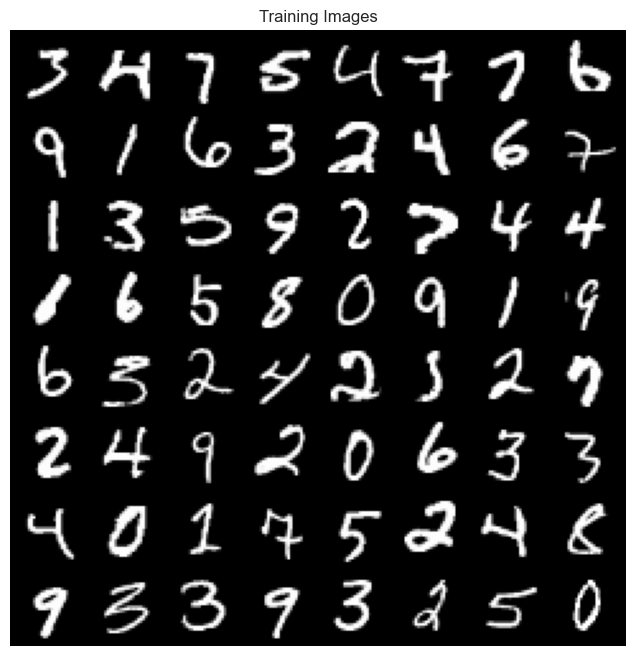

In [5]:
dataloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers, drop_last=True)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
# print(next(iter(dataloader)))
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [6]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [7]:
# build network
z_dim = 100
mnist_dim = mnist_trainset.train_data.size(1) * mnist_trainset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

/Users/shubov/PycharmProjects/gans/venv/lib/python3.9/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [8]:
mnist_dim

784

In [9]:
# loss
criterion = nn.BCELoss() 
fixed_noise = torch.randn(batch_size, z_dim, device=device)

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

In [10]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(batch_size, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on fake
    z = Variable(torch.randn(batch_size, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(batch_size, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

In [11]:

def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(batch_size, z_dim).to(device))
    y = Variable(torch.ones(batch_size, 1).to(device))
    # print("Z", z.shape)
    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [12]:
D_losses, G_losses, img_list = [], [], []
n_epoch = 10
for epoch in range(1, n_epoch+1):           
    for batch_idx, (x, _) in enumerate(dataloader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

        # Output training stats
        if batch_idx % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, n_epoch, batch_idx, len(dataloader),
                     D_losses[-1], G_losses[-1]))

        if epoch % 30 == 0:
          lr = lr/2 
          G_optimizer = optim.Adam(G.parameters(), lr = lr)
          D_optimizer = optim.Adam(D.parameters(), lr = lr)

        # Check how the generator is doing by saving G's output on fixed_noise
        if (batch_idx % 500 == 0) or ((epoch == n_epoch-1) and (batch_idx == len(dataloader)-1)):
            print("ADDING IMAGE")
            with torch.no_grad():
                fake = G(fixed_noise).detach().cpu()
            print(fake.shape)
            img_list.append(fake)



[1/10][0/937]	Loss_D: 1.3886	Loss_G: 0.6849
ADDING IMAGE
torch.Size([64, 784])
[1/10][50/937]	Loss_D: 0.1627	Loss_G: 2.7393
[1/10][100/937]	Loss_D: 1.2698	Loss_G: 1.1936
[1/10][150/937]	Loss_D: 1.7499	Loss_G: 2.7390
[1/10][200/937]	Loss_D: 0.5661	Loss_G: 2.4996
[1/10][250/937]	Loss_D: 0.1443	Loss_G: 6.7395
[1/10][300/937]	Loss_D: 0.2092	Loss_G: 3.9459
[1/10][350/937]	Loss_D: 0.1077	Loss_G: 8.4646
[1/10][400/937]	Loss_D: 0.2141	Loss_G: 4.4823
[1/10][450/937]	Loss_D: 0.3736	Loss_G: 2.6621
[1/10][500/937]	Loss_D: 0.4659	Loss_G: 2.9872
ADDING IMAGE
torch.Size([64, 784])
[1/10][550/937]	Loss_D: 0.3499	Loss_G: 4.5081
[1/10][600/937]	Loss_D: 1.7182	Loss_G: 1.1459
[1/10][650/937]	Loss_D: 1.4798	Loss_G: 3.4007
[1/10][700/937]	Loss_D: 0.9486	Loss_G: 2.8126
[1/10][750/937]	Loss_D: 0.3107	Loss_G: 5.0154
[1/10][800/937]	Loss_D: 1.4090	Loss_G: 0.5294
[1/10][850/937]	Loss_D: 0.8968	Loss_G: 2.9744
[1/10][900/937]	Loss_D: 1.4685	Loss_G: 1.4870
[2/10][0/937]	Loss_D: 1.1527	Loss_G: 0.8873
ADDING IMAGE
to

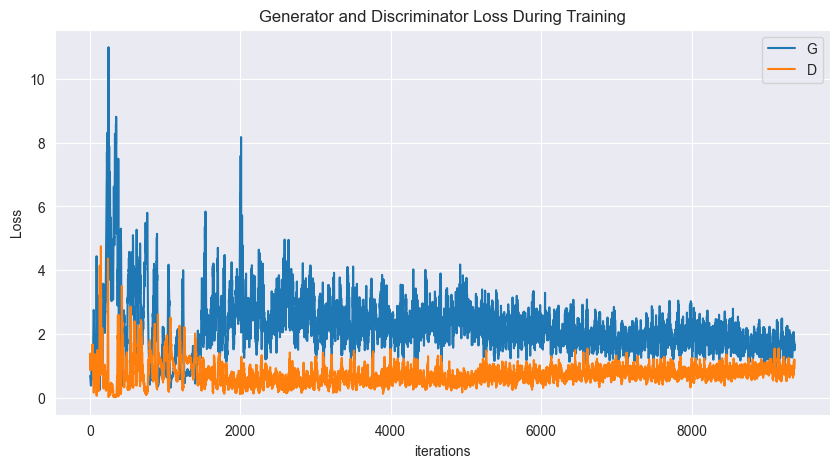

In [13]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [14]:
grid = img_list[0].unsqueeze(0).reshape(64, 1, 28, 28)

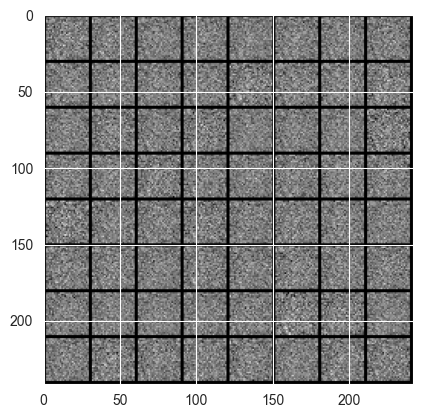

In [15]:
plt.imshow(np.transpose(vutils.make_grid(grid.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)).numpy())

/var/folders/jc/xkd5blwd6hz99wjjbm45kwsw0000gn/T/ipykernel_16921/2649971573.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


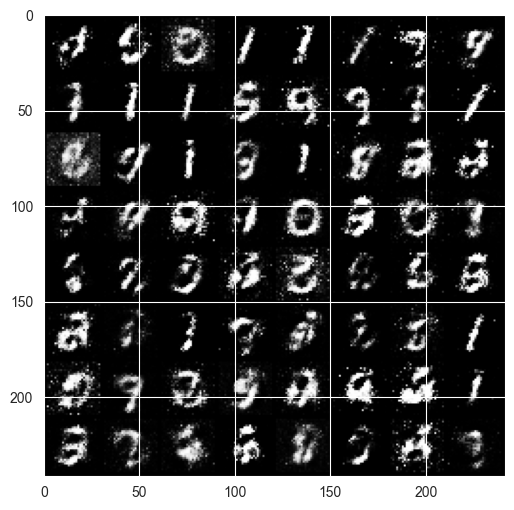

In [23]:
from celluloid import Camera
fig, ax = plt.subplots(figsize=(9,6)) # empty fig
ims = []
for grid in img_list:
  grid = grid.unsqueeze(0).reshape(64, 1, 28, 28)
  plt.imshow(np.transpose(vutils.make_grid(grid.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)).numpy())
fig.show()